## 잡플래닛 Jobplanet - 기업 별점 리뷰 데이터
- https://www.jobplanet.co.kr/
- **별점 리뷰**: 전체 리뷰 통계치 (5점 만점) 
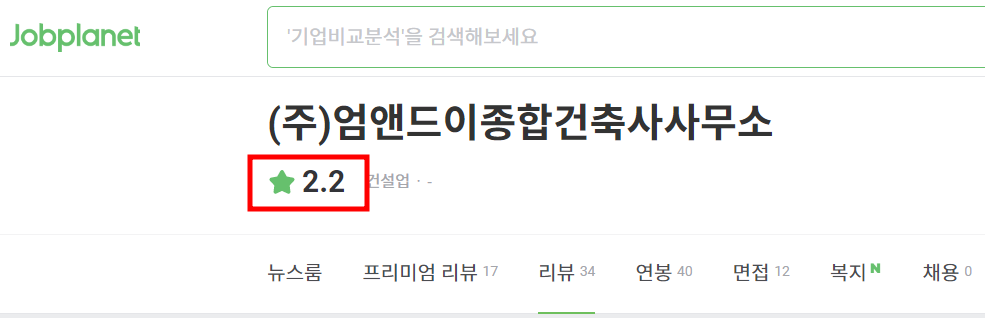
### 크롤링 관련 업체측 조건사항 준수
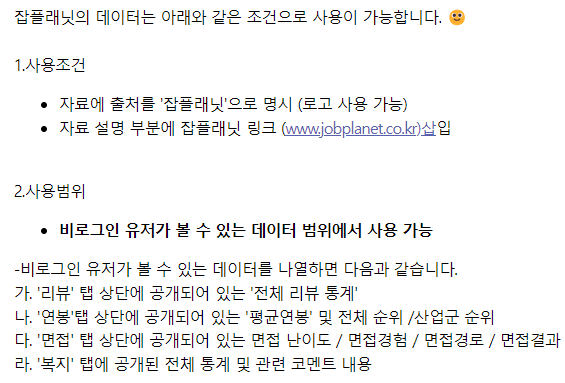

### 1) 기업 리뷰 링크 크롤링

In [12]:
import os
import sys
import urllib.request
import json
import re
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import requests
from bs4 import BeautifulSoup as bs
import warnings
warnings.filterwarnings('ignore')

### 2) NAVER API로 "기업명 + 대표자명 복수 키워드 검색"을 하여, 동일 상호명 중복 피함
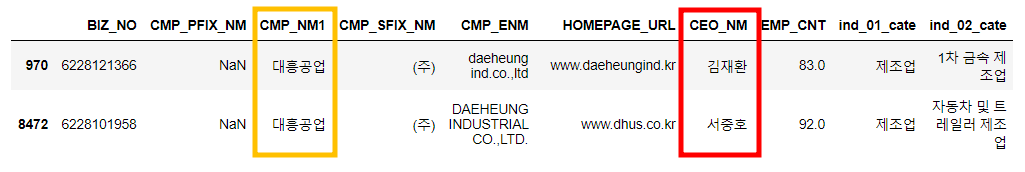

In [6]:
#기업명 및 대표자명 불러오기 
total_df = pd.read_excel('total_f_sbizdata.xlsx')

#대표자명에 '~외 n인' 문자열 제거 
ceo = total_df['CEO_NM'].replace('외 \d{1}명', '', regex=True)
cmp = total_df['CMP_NM']
ceo

0           홍순철
1        이스테판상수
2           김명화
3           김명구
4           김홍득
          ...  
35716       방건혁
35717       신남정
35718       윤인수
35719       임계현
35720       오석환
Name: CEO_NM, Length: 35721, dtype: object

In [62]:
# 네이버 Open API 정보입력
client_id = "k1g3Zx8nVTbbRmXRx3qS"
client_secret = "wzwAGiJ2md"
headers = {'user-agent': 'Mozilla/5.0'} 

web_df = pd.DataFrame(columns=('company', 'jobplanet_link'))
for idx in tqdm(range(len(total_df)):    
    encText = urllib.parse.quote(f'잡플래닛 {ceo[idx]} {cmp[idx]}')
    url = "https://openapi.naver.com/v1/search/webkr?query="+encText +"&display=2"
    request = urllib.request.Request(url, headers=headers)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if(rescode==200):
        response_body = response.read()
        response_dict = json.loads(response_body.decode('utf-8'))
        try:
            items = response_dict['items'] 
            for i in range(len(items)):
                if 'https://www.jobplanet.co.kr/companies/' in items[i]['link']:
                    company = cmp[idx]
                    link = items[i]['link']
                    web_df2.loc[idx] = [company, link]
        except:
            company = cmp[idx]
            link = np.nan
            web_df2.loc[idx] = [company, link]
    else: print("Error Code:" + rescode)

web_df

  0%|          | 0/15721 [00:00<?, ?it/s]

,company,jobplanet_link
20000,호전리테일,https://www.jobplanet.co.kr/companies/187205/r...
20001,한국회가내스,https://www.jobplanet.co.kr/companies/2886/lan...
20003,드림타워,https://www.jobplanet.co.kr/companies/296635/r...
20004,디케이프라임홀딩스,https://www.jobplanet.co.kr/companies/387749/r...
20005,케이앤에스컴퍼니,https://www.jobplanet.co.kr/companies/318826/i...
...,...,...
35710,도연개발,https://www.jobplanet.co.kr/companies/140935/l...
35716,게방식당팩토리,https://www.jobplanet.co.kr/companies/50877/be...
35718,윤월드푸드코리아다크써클브로스,https://www.jobplanet.co.kr/companies/371851/r...
35719,기린테크,https://www.jobplanet.co.kr/companies/92786/in...


### 3) 중간 결측치 확인

In [69]:
web_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27816 entries, 0 to 27815
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   company         27816 non-null  object
 1   jobplanet_link  27803 non-null  object
dtypes: object(2)
memory usage: 434.8+ KB


In [94]:
web_df.isnull().sum()

company              0
jobplanet_link    1377
dtype: int64

In [5]:
web_df.fillna('null',inplace=True)

### 4) 기업 별점 리뷰 데이터 크롤링

In [14]:
review = []
for url in tqdm(web_df['jobplanet_link']):
    if url != 'null':
        resp = requests.get(url, headers=headers)
        soup = bs(resp.text, 'lxml')
        post = soup.select('span.checkbox_text')
        stars = ' '.join(star.text[0] for star in post)[:1]
        review.append(stars)
    else: review.append('null')
web_df['review'] = review

  0%|          | 0/27816 [00:00<?, ?it/s]

### 5) 결측치 확인

In [46]:
web_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27816 entries, 0 to 27815
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   company         27816 non-null  object
 1   jobplanet_link  27816 non-null  object
 2   review          27816 non-null  object
dtypes: object(3)
memory usage: 869.2+ KB


In [9]:
web_df.replace('null', np.nan, inplace=True)
web_df.isnull().sum()

company              0
jobplanet_link    1377
review            4829
dtype: int64

In [10]:
web_df['review'].unique()

array([nan,  1.,  3.,  4.,  2.,  5.])

In [71]:
web_df = web_df.astype({'review':'float'})
web_df.head()

,company,jobplanet_link,review
0,한일가스산업,https://www.jobplanet.co.kr/companies/252598/r...,NaN
1,엠피아이,https://www.jobplanet.co.kr/companies/352071/r...,1.0
2,도영운수,https://www.jobplanet.co.kr/companies/97518/re...,1.0
3,중원산업,https://www.jobplanet.co.kr/companies/55705/re...,1.0
4,엄앤드이종합건축사사무소,https://www.jobplanet.co.kr/companies/93411/re...,1.0


In [11]:
web_df.to_excel('web_df_prep.xlsx')